# INM433 Visual Analytics: Lab03

# Part 1 Distribution & Patterns

The overall goal of this exercise is to practice visual exploration of distributions for identifying and interpreting patterns in distributions. The exercise includes:
<ul>
    <li>Exploration of temporal and spatial distributions of discrete entities using time histograms and maps. </li>
    <li>Exploration of a joint distribution of multiple attributes over a set of entities using spatialisation.</li>
</ul>

For a more detailed description, refer to the exercise description document.

A video demonstrating interactive data exploration using V-Analytics is: <a href=distributions.mp4>distributions.mp4</a>

If <i>folium</i> is not installed on your computer, execute the following command

<pre>conda install -c conda-forge folium geopandas tornado==4.5.3</pre>

- **Use Seaborn version 0.11.1 in this notebook for not having any error in Cell #9**

## Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import folium
from folium.plugins import HeatMap
#from sklearn.cluster import KMeans
#from sklearn.decomposition import PCA
from collections import Counter

np.random.seed(123)

import warnings
warnings.filterwarnings('ignore')

### Load a dataset describing storm-related tweets

In [2]:
df = pd.read_csv('storm_tweets.csv')
df.head(10)

id           Name         X          Y  LONGITUDE  \
0  581338551868063744          storm  0.071042  52.094433   0.071042   
1  581312068629954560           wind -3.086356  53.060090  -3.086356   
2  581274239308832769          flood -1.118795  52.617813  -1.118795   
3  581347370438393856          storm -0.462822  53.219820  -0.462822   
4  581346808099684352        disrupt  0.012129  50.870740   0.012129   
5  581270572723634176       forecast  0.252533  51.511170   0.252533   
6  581342565477277696      wind;rain -4.264500  55.453500  -4.264500   
7  581335562138714112  rain;forecast -1.476630  52.922770  -1.476630   
8  581344323721170944          storm -0.232172  51.491104  -0.232172   
9  581344763741396992          storm -0.323126  51.576023  -0.323126   

    LATITUDE          MESSAGEDATE   USERSCREENNAME  \
0  52.094433  27/03/2015 06:14:46      Willis12Pat   
1  53.060089  27/03/2015 04:29:32  secondhand_shed   
2  52.617813  27/03/2015 01:59:12     DrJonMillett   
3  53.219818  27/03/2015 06:49:48   CunninghamKian   
4  50.870739  27/03/2015 06:47:34   philhillslewes   
5  51.511169  27/03/2015 01:44:38  TheMockneyRebel   
6  55.453499  27/03/2015 06:30:43      twt_wthr_py   
7  52.922771  27/03/2015 06:02:53      DailyDERBYS   
8  51.491104  27/03/2015 06:37:42           F1taxi   
9  51.576023  27/03/2015 06:39:27         allyc375   

                                         MESSAGETEXT                 LOCATION  \
0  Love retirement!  My day.. The 7's taping the ...        Fowlmere; England   
1  @tonywilliams68 @wrexham strong winds sorry ;i...            Minera; Wales   
2  @Leicester_Merc New street lamp is like living...       Leicester; England   
3  The calm before the storm ... http://t.co/7Pv5...  Washingborough; England   
4  @NRE_Southern @brightonstation what about disr...           Lewes; England   
5  Guardian/ICM survey puts Labour in line to gai...          Aveley; England   
6  Sat: max 10C feels 6C Wind W 27mph Rain 97% He...        Cumnock; Scotland   
7  Sunday: Heavy Rain Shower; Maximum Temperature...           Derby; England   
8  @MercedesAMGF1 getting hotter any chance of a ...      Hammersmith; London   
9  Tip for maintaining remnants of sanity. Get up...            Brent; London   

   ... keyword=road keyword=collapse  keyword=ingury  keyword=disrupt  \
0  ...            0                0               0                0   
1  ...            0                0               0                0   
2  ...            0                0               0                0   
3  ...            0                0               0                0   
4  ...            0                0               0                1   
5  ...            0                0               0                0   
6  ...            0                0               0                0   
7  ...            0                0               0                0   
8  ...            0                0               0                0   
9  ...            0                0               0                0   

   keyword=forecast         Mask  bad weather (sum)  consequence (sum)  \
0                 0  10000000000                1.0                0.0   
1                 0   1000000000                1.0                0.0   
2                 0       100000                0.0                1.0   
3                 0  10000000000                1.0                0.0   
4                 0           10                0.0                1.0   
5                 1            1                0.0                0.0   
6                 0   1100000000                2.0                0.0   
7                 1    100000001                1.0                0.0   
8                 0  10000000000                1.0                0.0   
9                 0  10000000000                1.0                0.0   

   bad weather  consequence  
0          1.0          0.0  
1          1.0          0.0  
2          0.0          1.0  


### Transforming dates

In [3]:
df['msgdate']=pd.to_datetime(df['MESSAGEDATE'], 
                             format="%d/%m/%Y %H:%M:%S")

df.msgdate.head(10)

0   2015-03-27 06:14:46
1   2015-03-27 04:29:32
2   2015-03-27 01:59:12
3   2015-03-27 06:49:48
4   2015-03-27 06:47:34
5   2015-03-27 01:44:38
6   2015-03-27 06:30:43
7   2015-03-27 06:02:53
8   2015-03-27 06:37:42
9   2015-03-27 06:39:27
Name: msgdate, dtype: datetime64[ns]

In [4]:
df['MESSAGEDATE'] = pd.to_datetime(df['MESSAGEDATE'],
                                   format='%d/%m/%Y %H:%M:%S')

print('The column MESSAGEDATE is of type :', df.MESSAGEDATE.dtype)

print('The min value of MESSAGEDATE is', df.MESSAGEDATE.min(), 'whereas the max is :', df.MESSAGEDATE.max())

The column MESSAGEDATE is of type : datetime64[ns]
The min value of MESSAGEDATE is 2015-03-27 00:06:29 whereas the max is : 2015-04-02 13:40:59


## Visual exploration of the temporal distribution of the tweets
We shall visualise the temporal distribution by means of time histograms showing the counts of the posted tweets by hourly and daily time intervals.

The index type of the dataframe is <class 'pandas.core.indexes.datetimes.DatetimeIndex'> 

The highest value of the hourly count was 72 and was reached on 2015-03-30 23:00:00


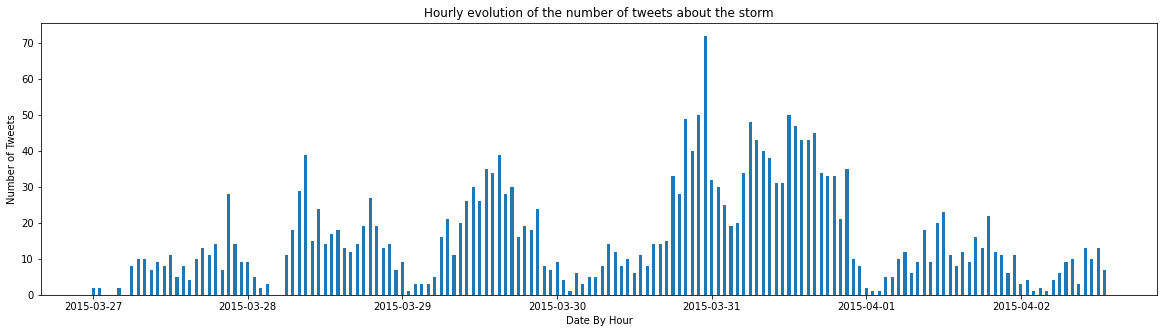

In [5]:
# In order to inspect temporal distribution and aggregate the time attribute flexibly,
# it's interesting to set the MESSAGEDATE column as an index of the dataframe, this will allow us to use the 
# powerful resample() method !

df.set_index(df['MESSAGEDATE'], inplace=True)

print('The index type of the dataframe is', type(df.index), '\n')# Let's refine the analysis by inspecting the temporal distribution by HOUR

df_count_hourly = df.resample('H').count()[['MESSAGETEXT']]

# Display the peak of the hourly count
print('The highest value of the hourly count was', df_count_hourly.MESSAGETEXT.max(), 'and was reached on', df_count_hourly.MESSAGETEXT.idxmax())

# Visualize the evolution
plt.figure(figsize = (20, 5))
plt.xlabel('Date By Hour')
plt.ylabel('Number of Tweets')
plt.title('Hourly evolution of the number of tweets about the storm')

plt.bar(df_count_hourly.index, 
        df_count_hourly.values.flatten(), 
        width = 0.02);

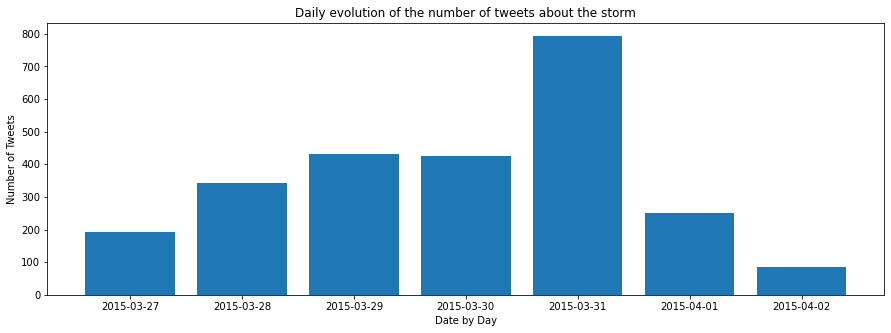

In [6]:
# In order to inspect temporal distribution and aggregate the time attribute flexibly,
# it's interesting to set the MESSAGEDATE column as an index of the dataframe, this will allow us to use the 
# powerful resample() method !

#df.set_index(df['MESSAGEDATE'], inplace=True)
#print('The index type of the dataframe is', type(df.index), '\n')

# Inspecting the temporal distribution by DAY
df_count_daily = df.resample('D').count()[['MESSAGETEXT']]

# Visualize the evolution
plt.figure(figsize = (15, 5))
plt.xlabel('Date by Day')
plt.ylabel('Number of Tweets')
plt.title('Daily evolution of the number of tweets about the storm')

plt.bar(df_count_daily.index, 
        df_count_daily.values.flatten());

## Task: find different types of temporal patterns in the hourly and daily distributions
Possible types of temporal patterns to look for: increasing and decreasing trends, jump, drop, peak, trough, periodic repetition of some kind of pattern.

### Apply smoothing to the representation of the temporal distribution
Smoothing by means of kernel density estimation (KDE) increases the level of abstraction in representing the temporal distribution. We can disregard small fluctuations and moderate variation in the tweet number and see the overall temporal trend.<br>
<strong>Please note:</strong> KDE represents the data using a continuous <em>probability density</em> curve. The vertical axis of the plot represents the probability denstity rather than absolute counts of the tweets.<br>
In our example, we create two curves with different levels of smoothing.

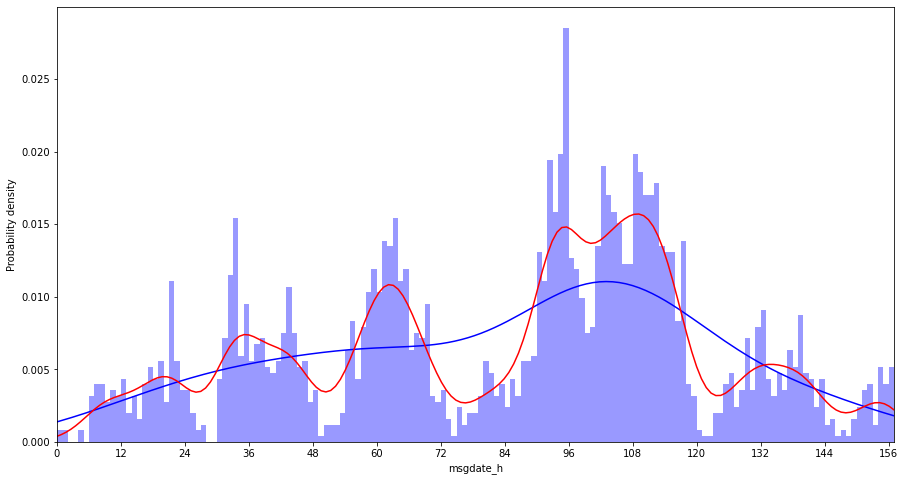

In [7]:
# Using Seaborn to make nicer plots + using KDE (kernal density estimate)
plt.figure(figsize=(15,8))
plt.xlabel('Hour')
plt.xlim(0, 157)
plt.xticks(np.arange(0, 157, 12))
plt.ylabel('Probability density')

df['msgdate_h']=(pd.to_datetime(df.msgdate)-pd.to_datetime(df.msgdate.min().date())).astype('int64')/1000000000/3600

sns.distplot(df.msgdate_h, 
             bins=range(0,int(round(df.msgdate_h.max()))+1,1), 
             kde_kws={'bw': 0.4}, 
             color="blue");

sns.distplot(df.msgdate_h, 
             bins=range(0,int(round(df.msgdate_h.max()))+1,1), 
             kde_kws={'bw': 0.1}, 
             color="red", 
             hist=False);

# The value of the parameter "bw" regulates the smoothing bandwidth: 
# the larger the value, the more smoothing is applied.

# bw value has been changed to 0.4 and 0.1 for blue and red line respectively 
# to observe the smoothing difference.

While the smoothing in blue curve is high, the one in red curve is lower and we can clearly observe that it is aligns with the histogram better.

## Task: compare the smoothed representation with the original time histogram
What patterns can be seen only in the original histogram? What patterns are better visible in the smoothed representation?<br>
Regulate the smoothing level by means of the parameter <b>'bw'</b> (bandwidth), which is in this case the width of the time window, measured in hours. Larger values increase the smoothing level.

### Visualise the frequency distribution of the occurrences of different keywords
We use a frequency histogram to look at the total counts of the keyword occurrences.

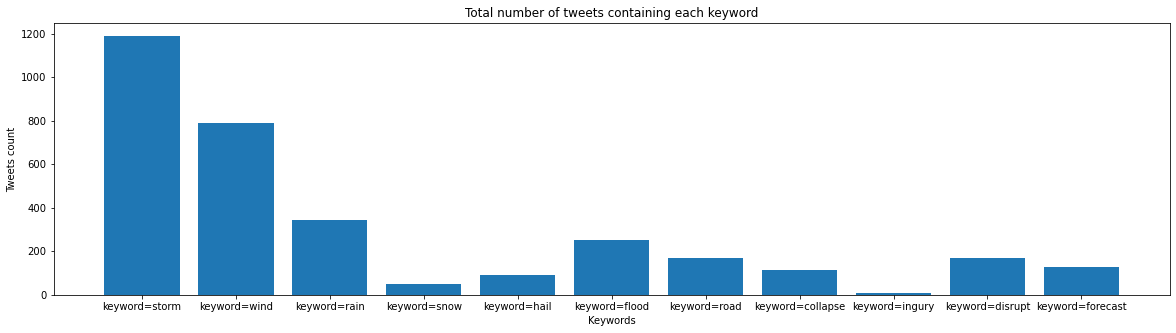

In [8]:
# Listing keywords
keywords = ['keyword=storm', 
            'keyword=wind', 
            'keyword=rain', 
            'keyword=snow', 
            'keyword=hail', 
            'keyword=flood', 
            'keyword=road', 
            'keyword=collapse', 
            'keyword=ingury', 
            'keyword=disrupt', 
            'keyword=forecast']

# Visualizing the total occurence of the keywords
plt.figure(figsize=(20, 5))
plt.xlabel('Keywords')
plt.ylabel('Tweets count')
plt.title('Total number of tweets containing each keyword')

plt.bar(keywords, 
        df[keywords].sum());

### Visualise the temporal distributions of the occurrences of the different keywords
The temporal distributions are visualised in the form of probability density curves built by means of KDE.

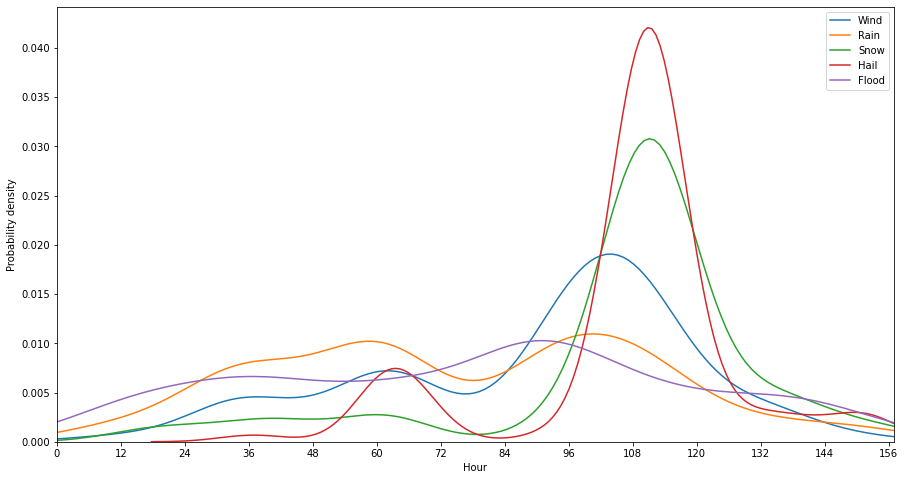

In [9]:
# Plotting the temporal distributions of the occurrences of different keywords in the form of probability density curves
plt.figure(figsize=(15,8))
plt.xlabel('Hour')
plt.ylabel('Probability density')
plt.xlim(0, 157)
plt.xticks(np.arange(0, 157, 12))

df['msgdate_h'] = (pd.to_datetime(df.msgdate) - pd.to_datetime(df.msgdate.min().date())).astype('int64')/1000000000/3600

#sns.kdeplot(df.msgdate_h, label="Totals", bw=4)
#sns.kdeplot(df[df['keyword=storm']>0].msgdate_h, label="Storm", bw=4)

sns.kdeplot(df[df['keyword=wind']>0].msgdate_h, label="Wind", bw=0.3)
sns.kdeplot(df[df['keyword=rain']>0].msgdate_h, label="Rain", bw=0.3)
sns.kdeplot(df[df['keyword=snow']>0].msgdate_h, label="Snow", bw=0.3)
sns.kdeplot(df[df['keyword=hail']>0].msgdate_h, label="Hail", bw=0.3)
sns.kdeplot(df[df['keyword=flood']>0].msgdate_h, label="Flood", bw=0.3)

#sns.kdeplot(df[df['keyword=road']>0].msgdate_h, label="Road", bw=4)
#sns.kdeplot(df[df['keyword=collapse']>0].msgdate_h, label="Collapse", bw=4)
#sns.kdeplot(df[df['keyword=ingury']>0].msgdate_h, label="Ingury", bw=4)
#sns.kdeplot(df[df['keyword=disrupt']>0].msgdate_h, label="Disrupt", bw=4)
#sns.kdeplot(df[df['keyword=forecast']>0].msgdate_h, label="Forecast", bw=4)

plt.legend();

## Task: compare the temporal distribution patterns of the different keywords
Please comment and uncomment different lines of the code to for a better visibility and easier comparison of the distribution patterns of the different keywords.

### Visualise the spatial distribution of the tweets on a map
We first build a map where each tweet is represented by a dot. The dots have low opacity; hence, concentrations of dots appear as dark spots on the map. This allows you to observe the variation of the spatial density of the tweets over the territory and detect spatial clusters of tweets.

In [10]:
xmm=(df.X.min()+df.X.max())/2
ymm=(df.Y.min()+df.Y.max())/2

map = folium.Map(location=[ymm,xmm], zoom_start=6, width=600,height=700)

df.apply(lambda row:folium.CircleMarker(location=[row["Y"], row["X"]], 
                                        radius=3, 
                                        opacity=.05, 
                                        color='#cc0000').add_to(map), 
         axis=1)

map

### Replace the dots by a density map (a.k.a. heatmap)
This operation represents the spatial distribution as a smooth continuous surface.

In [11]:
xmm=(df.X.min()+df.X.max())/2
ymm=(df.Y.min()+df.Y.max())/2

hmap = folium.Map(location=[ymm,xmm], 
                  zoom_start=6, 
                  width=600,
                  height=700)

hm_wide = HeatMap(list(zip(df.LATITUDE.values, df.LONGITUDE.values)), 
                  min_opacity=0.2,
                  radius=10, 
                  blur=15, 
                  max_zoom=1)

hmap.add_child(hm_wide)

### Change the colour scale and the level of smoothing
We replace the "rainbow" colour scale, which is not recommended for representing numeric data, by a better one.<br>
The smoothing level is controlled by the value of the parameter 'radius'. Change the value of this parameter to observe its impact on the visible patterns.

In [12]:
xmm=(df.X.min()+df.X.max())/2
ymm=(df.Y.min()+df.Y.max())/2

hmap = folium.Map(location=[ymm,xmm], 
                  zoom_start=6, 
                  width=600,
                  height=700)

hm_wide = HeatMap(list(zip(df.LATITUDE.values, df.LONGITUDE.values)), 
                  min_opacity=0.2,
                  #radius=5,
                  radius=4.5,
                  blur=10, 
                  # Adjusting the radius will make areas more distiNct, and reducing blur will make map clearer!
                  max_zoom=1, 
                  gradient={.5: 'blue', .75: 'orange', 0.9: 'red'})

hmap.add_child(hm_wide)

## Task: characterise the spatial distribution of the tweets in terms of the variation of the spatial density.
What are the places where you observe high density of the tweets? How can you explain this pattern of the spatial distribution?

### Visualise the spatial distributions of the occurrences of different keywords
In the following two cells, we select the table rows with the occurrences of two different keywords, so that the spatial distributions of their occurrences could be compared.<br>
Select the rows containing other keywords to explore and compare the spatial distributions of these keywords.

In [13]:
xmm=(df.X.min()+df.X.max())/2
ymm=(df.Y.min()+df.Y.max())/2

hmap = folium.Map(location=[ymm,xmm], 
                  zoom_start=6, 
                  width=600,
                  height=700)

# Change the selection of the rows according to the keyword occurrence to observe the spatial distributions of the occurrences of different keywords
hm_wide = HeatMap(list(zip(df[df['keyword=rain']>0].LATITUDE.values, 
                           df[df['keyword=rain']>0].LONGITUDE.values)), 
                  min_opacity=0.2,
                  radius=7, 
                  blur=10, 
                  max_zoom=1, 
                  gradient={.6: 'blue', .9: 'orange', 1: 'red'}) 

hmap.add_child(hm_wide)

In [14]:
xmm=(df.X.min()+df.X.max())/2
ymm=(df.Y.min()+df.Y.max())/2

hmap = folium.Map(location=[ymm,xmm], 
                  zoom_start=6, 
                  width=600,
                  height=700)

# Change the selection of the rows according to the keyword occurrence to observe the spatial distributions # of the occurrences of different keywords
hm_wide = HeatMap(list(zip(df[df['keyword=hail']>0].LATITUDE.values, 
                           df[df['keyword=hail']>0].LONGITUDE.values)), 
                  min_opacity=0.2,
                  radius=7, 
                  blur=10, 
                  max_zoom=1, 
                  gradient={.6: 'blue', .9: 'orange', 1: 'red'}) 

hmap.add_child(hm_wide)

## Task: note and interpret differences in the spatial distributions of different keywords.
The distributions of which keywords notably differ from the overall distribution of the tweets? Are there places where certain events or phenomena had higher impact (or raised higher reaction in the social media) that in other places?


# Part 2 Spatialisation

In this part of the exercise, we shall perform spatialisation of multidimensional (multi-attribute) data by means of the method called Multi-Dimensional Scaling, abbreviated as MDS. We shall apply MDS to data obtained by aggregating the original storm-related tweets into hourly counts and percentages of occurrences of different keywords. Attempts to apply MDS to the original data failed because the method is not very efficient and takes too much time to run when the number of data records is large.

After loading the aggregated data, we shall first spatialise the keywords according to the temporal variation of their occurrences, and then we shall spatialise the hourly intervals according to the occurrences of the keywords.

In [15]:
# Importing Libraries
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

#from sklearn.decomposition import PCA
from sklearn.manifold import MDS

import folium

from collections import Counter

np.random.seed(123)

import warnings
warnings.filterwarnings('ignore')

### Load aggregated data describing the temporal variation of the keyword occurrences

In [16]:
# Loading csv file into Pandas DataFrame
kw = pd.read_csv('keywords.csv')
kw

id      Name  27.03;00: count  27.03;01: count  27.03;02: count  \
0      storm     storm                0                1                0   
1       wind      wind                0                0                0   
2       rain      rain                0                0                0   
3       snow      snow                0                0                0   
4       hail      hail                0                0                0   
5      flood     flood                1                1                0   
6       road      road                0                0                0   
7   collapse  collapse                1                0                1   
8     ingury    ingury                2                0                0   
9    disrupt   disrupt                0                0                0   
10  forecast  forecast                0                1                0   

    27.03;03: count  27.03;04: count  27.03;05: count  27.03;06: count  \
0                 0                1                0                6   
1                 0                1                0                1   
2                 0                0                0                2   
3                 0                0                0                0   
4                 0                0                0                0   
5                 0                0                1                0   
6                 0                0                0                0   
7                 0                0                1                0   
8                 0                0                0                0   
9                 0                0                0                1   
10                0                0                1                1   

    27.03;07: count  ...  02.04;04: %  02.04;05: %  02.04;06: %  02.04;07: %  \
0                 3  ...          0.0         40.0         12.5         16.7   
1                 1  ...          0.0          0.0         37.5         16.7   
2                 3  ...         50.0          0.0         12.5         25.0   
3                 0  ...          0.0          0.0          0.0          0.0   
4                 0  ...          0.0         20.0         12.5          8.3   
5                 1  ...          0.0          0.0          0.0          8.3   
6                 0  ...          0.0          0.0          0.0          0.0   
7                 2  ...          0.0          0.0          0.0          8.3   
8                 1  ...          0.0          0.0          0.0          0.0   
9                 1  ...          0.0         40.0         25.0          8.3   
10                1  ...         50.0          0.0          0.0          8.3   

    02.04;08: %  02.04;09: %  02.04;10: %  02.04;11: %  02.04;12: %  \
0          27.3         33.3         57.1         46.7         40.0   
1           9.1          0.0          0.0          0.0          6.7   
2           0.0          0.0          0.0         20.0          0.0   
3           0.0          0.0          0.0          0.0          6.7   
4           9.1          0.0          0.0          0.0          0.0   
5           0.0         33.3         14.3         13.3          6.7   
6           0.0          0.0          0.0          0.0          0.0   
7           9.1          0.0          0.0          6.7         20.0   
8           0.0          0.0          0.0          0.0          0.0   
9          36.4         33.3         28.6          6.7         20.0   
10          9.1          0.0          0.0          6.7          0.0   

    02.04;13: %  
0          44.4  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
5          33.3  
6           0.0  
7           0.0  
8           0.0  
9          22.2  
10          0.0  

[11 rows x 318 columns]

The table contains two groups of columns with numeric values: 158 columns with the absolute hourly counts of the occurrences of the keywords and 158 columns with the percentages of the occurrences of the keywords among all occurrences. We shall apply spatialisation separately to each group of columns.

First, we create selections of the two groups of columns.

### Select the columns with the absolute counts of the keyword occurrences

In [17]:
kw_abs_counts = kw.iloc[:, 2:160]
kw_abs_counts.index = kw.iloc[:,0]
kw_abs_counts

27.03;00: count  27.03;01: count  27.03;02: count  27.03;03: count  \
id                                                                             
storm                   0                1                0                0   
wind                    0                0                0                0   
rain                    0                0                0                0   
snow                    0                0                0                0   
hail                    0                0                0                0   
flood                   1                1                0                0   
road                    0                0                0                0   
collapse                1                0                1                0   
ingury                  2                0                0                0   
disrupt                 0                0                0                0   
forecast                0                1                0                0   

          27.03;04: count  27.03;05: count  27.03;06: count  27.03;07: count  \
id                                                                             
storm                   1                0                6                3   
wind                    1                0                1                1   
rain                    0                0                2                3   
snow                    0                0                0                0   
hail                    0                0                0                0   
flood                   0                1                0                1   
road                    0                0                0                0   
collapse                0                1                0                2   
ingury                  0                0                0                1   
disrupt                 0                0                1                1   
forecast                0                1                1                1   

          27.03;08: count  27.03;09: count  ...  02.04;04: count  \
id                                          ...                    
storm                   2                5  ...                0   
wind                    0                2  ...                0   
rain                    0                1  ...                1   
snow                    0                0  ...                0   
hail                    0                0  ...                0   
flood                   6                1  ...                0   
road                    0                0  ...                0   
collapse                2                1  ...                0   
ingury                  0                1  ...                0   
disrupt                 2                0  ...                0   
forecast                0                1  ...                1   

          02.04;05: count  02.04;06: count  02.04;07: count  02.04;08: count  \
id                                                                             
storm                   2                1                2                3   
wind                    0                3                2                1   
rain                    0                1                3                0   
snow                    0                0                0                0   
hail                    1                1                1                1   
flood                   0                0                1                0   
road                    0                0                0                0   
collapse                0                0                1                1   
ingury                  0                0                0                0   
disrupt                 2                2                1                4   
forecast                0                0                1                1   

  

### Select the columns containing the percentages of the keyword occurrences

In [18]:
kw_percentages = kw.iloc[:, 160:318]
kw_percentages.index = kw.iloc[:,0]
kw_percentages

27.03;00: %  27.03;01: %  27.03;02: %  27.03;03: %  27.03;04: %  \
id                                                                          
storm             0.0         33.3          0.0          0.0         50.0   
wind              0.0          0.0          0.0          0.0         50.0   
rain              0.0          0.0          0.0          0.0          0.0   
snow              0.0          0.0          0.0          0.0          0.0   
hail              0.0          0.0          0.0          0.0          0.0   
flood            25.0         33.3          0.0          0.0          0.0   
road              0.0          0.0          0.0          0.0          0.0   
collapse         25.0          0.0        100.0          0.0          0.0   
ingury           50.0          0.0          0.0          0.0          0.0   
disrupt           0.0          0.0          0.0          0.0          0.0   
forecast          0.0         33.3          0.0          0.0          0.0   

          27.03;05: %  27.03;06: %  27.03;07: %  27.03;08: %  27.03;09: %  \
id                                                                          
storm             0.0         54.5         23.1         16.7         41.7   
wind              0.0          9.1          7.7          0.0         16.7   
rain              0.0         18.2         23.1          0.0          8.3   
snow              0.0          0.0          0.0          0.0          0.0   
hail              0.0          0.0          0.0          0.0          0.0   
flood            33.3          0.0          7.7         50.0          8.3   
road              0.0          0.0          0.0          0.0          0.0   
collapse         33.3          0.0         15.4         16.7          8.3   
ingury            0.0          0.0          7.7          0.0          8.3   
disrupt           0.0          9.1          7.7         16.7          0.0   
forecast         33.3          9.1          7.7          0.0          8.3   

          ...  02.04;04: %  02.04;05: %  02.04;06: %  02.04;07: %  \
id        ...                                                       
storm     ...          0.0         40.0         12.5         16.7   
wind      ...          0.0          0.0         37.5         16.7   
rain      ...         50.0          0.0         12.5         25.0   
snow      ...          0.0          0.0          0.0          0.0   
hail      ...          0.0         20.0         12.5          8.3   
flood     ...          0.0          0.0          0.0          8.3   
road      ...          0.0          0.0          0.0          0.0   
collapse  ...          0.0          0.0          0.0          8.3   
ingury    ...          0.0          0.0          0.0          0.0   
disrupt   ...          0.0         40.0         25.0          8.3   
forecast  ...         50.0          0.0          0.0          8.3   

          02.04;08: %  02.04;09: %  02.04;10: %  02.04;11: %  02.04;12: %  \
id                                                                          
storm            27.3         33.3         57.1         46.7         40.0   
wind              9.1          0.0          0.0          0.0          6.7   
rain              0.0          0.0          0.0         20.0          0.0   
snow              0.0          0.0          0.0          0.0          6.7   
hail              9.1          0.0          0.0          0.0          0.0   
flood             0.0         33.3         14.3         13.3          6.7   
road              0.0          0.0          0.0          0.0          0.0   
collapse          9.1          0.0          0.0          6.7         20.0   
ingury            0.0          0.0          0.0          0.0          0.0   
disrupt          36.4         33.3         28.6          6.7         20.0   
forecast          9.1          0.0          0.0          6.7          0.0   

          02.04;13: %  
id                     
storm            44.4  
wind              0.0  
rain      

### Reducing the column names to the dates+hours only
We shall later use the column names as labels; therefore, we reduce their lengths by removing repeated substrings. We do this for both column selections (counts and percentages).

In [19]:
dates = []
for column in kw_percentages.columns:
    dates.append(column[0:8])
    
kw_percentages.columns = dates
kw_percentages

27.03;00  27.03;01  27.03;02  27.03;03  27.03;04  27.03;05  \
id                                                                     
storm          0.0      33.3       0.0       0.0      50.0       0.0   
wind           0.0       0.0       0.0       0.0      50.0       0.0   
rain           0.0       0.0       0.0       0.0       0.0       0.0   
snow           0.0       0.0       0.0       0.0       0.0       0.0   
hail           0.0       0.0       0.0       0.0       0.0       0.0   
flood         25.0      33.3       0.0       0.0       0.0      33.3   
road           0.0       0.0       0.0       0.0       0.0       0.0   
collapse      25.0       0.0     100.0       0.0       0.0      33.3   
ingury        50.0       0.0       0.0       0.0       0.0       0.0   
disrupt        0.0       0.0       0.0       0.0       0.0       0.0   
forecast       0.0      33.3       0.0       0.0       0.0      33.3   

          27.03;06  27.03;07  27.03;08  27.03;09  ...  02.04;04  02.04;05  \
id                                                ...                       
storm         54.5      23.1      16.7      41.7  ...       0.0      40.0   
wind           9.1       7.7       0.0      16.7  ...       0.0       0.0   
rain          18.2      23.1       0.0       8.3  ...      50.0       0.0   
snow           0.0       0.0       0.0       0.0  ...       0.0       0.0   
hail           0.0       0.0       0.0       0.0  ...       0.0      20.0   
flood          0.0       7.7      50.0       8.3  ...       0.0       0.0   
road           0.0       0.0       0.0       0.0  ...       0.0       0.0   
collapse       0.0      15.4      16.7       8.3  ...       0.0       0.0   
ingury         0.0       7.7       0.0       8.3  ...       0.0       0.0   
disrupt        9.1       7.7      16.7       0.0  ...       0.0      40.0   
forecast       9.1       7.7       0.0       8.3  ...      50.0       0.0   

          02.04;06  02.04;07  02.04;08  02.04;09  02.04;10  02.04;11  \
id                                                                     
storm         12.5      16.7      27.3      33.3      57.1      46.7   
wind          37.5      16.7       9.1       0.0       0.0       0.0   
rain          12.5      25.0       0.0       0.0       0.0      20.0   
snow           0.0       0.0       0.0       0.0       0.0       0.0   
hail          12.5       8.3       9.1       0.0       0.0       0.0   
flood          0.0       8.3       0.0      33.3      14.3      13.3   
road           0.0       0.0       0.0       0.0       0.0       0.0   
collapse       0.0       8.3       9.1       0.0       0.0       6.7   
ingury         0.0       0.0       0.0       0.0       0.0       0.0   
disrupt       25.0       8.3      36.4      33.3      28.6       6.7   
forecast       0.0       8.3       9.1       0.0       0.0       6.7   

          02.04;12  02.04;13  
id                            
storm         40.0      44.4  
wind           6.7       0.0  
rain           0.0       0.0  
snow           6.7       0.0  
hail           0.0       0.0  
flood          6.7      33.3  
road           0.0       0.0  
collapse      20.0       0.0  
ingury         0.0       0.0  
disrupt       20.0      22.2  
forecast       0.0       0.0  

[11 rows x 158 columns]

In [20]:
kw_abs_counts.columns=dates
kw_abs_counts

27.03;00  27.03;01  27.03;02  27.03;03  27.03;04  27.03;05  \
id                                                                     
storm            0         1         0         0         1         0   
wind             0         0         0         0         1         0   
rain             0         0         0         0         0         0   
snow             0         0         0         0         0         0   
hail             0         0         0         0         0         0   
flood            1         1         0         0         0         1   
road             0         0         0         0         0         0   
collapse         1         0         1         0         0         1   
ingury           2         0         0         0         0         0   
disrupt          0         0         0         0         0         0   
forecast         0         1         0         0         0         1   

          27.03;06  27.03;07  27.03;08  27.03;09  ...  02.04;04  02.04;05  \
id                                                ...                       
storm            6         3         2         5  ...         0         2   
wind             1         1         0         2  ...         0         0   
rain             2         3         0         1  ...         1         0   
snow             0         0         0         0  ...         0         0   
hail             0         0         0         0  ...         0         1   
flood            0         1         6         1  ...         0         0   
road             0         0         0         0  ...         0         0   
collapse         0         2         2         1  ...         0         0   
ingury           0         1         0         1  ...         0         0   
disrupt          1         1         2         0  ...         0         2   
forecast         1         1         0         1  ...         1         0   

          02.04;06  02.04;07  02.04;08  02.04;09  02.04;10  02.04;11  \
id                                                                     
storm            1         2         3         1         8         7   
wind             3         2         1         0         0         0   
rain             1         3         0         0         0         3   
snow             0         0         0         0         0         0   
hail             1         1         1         0         0         0   
flood            0         1         0         1         2         2   
road             0         0         0         0         0         0   
collapse         0         1         1         0         0         1   
ingury           0         0         0         0         0         0   
disrupt          2         1         4         1         4         1   
forecast         0         1         1         0         0         1   

          02.04;12  02.04;13  
id                            
storm            6         4  
wind             1         0  
rain             0         0  
snow             1         0  
hail             0         0  
flood            1         3  
road             0         0  
collapse         3         0  
ingury           0         0  
disrupt          3         2  
forecast         0         0  

[11 rows x 158 columns]

### This function generates a color according to a position in a projection
This function will be further used for colouring dots and lines in plots.

In [21]:
import math
def getColor (x, y, minX, maxX, minY, maxY):
    wX=maxX-minX 
    wY=maxY-minY
    rr=y-minY 
    cc=x-minX
    #print(x,y)
    if (wY < wX):   #scale vertically, i.e. modify rr
        rr *= wX/wY  
    else:           #scale horizontally, i.e. modify cc
        cc *= wY/wX
    maxD=max(wX,wY)
    rr1=maxD-rr
    cc1=maxD-cc
    #print(rr,cc,maxD,rr1,cc1)
    dc=[math.sqrt(rr*rr+cc*cc),math.sqrt(rr*rr+cc1*cc1),math.sqrt(rr1*rr1+cc*cc),math.sqrt(rr1*rr1+cc1*cc1)]
    weights=[0.0,0.0,0.0,0.0]
    for i in range(len(weights)):
        weights[i]=(maxD-dc[i])/maxD
        if (weights[i]<0):
            weights[i]=0
    #print(dc,weights)
    reds=[228,25,255,37]
    greens=[220,228,18,13]
    blues=[0,218,6,252]
    dr=0
    dg=0
    db=0
    for i,weight in enumerate(weights):
        dr += weight*reds[i]
        dg += weight*greens[i]
        db += weight*blues[i]
    if (dr<0):
        dr=0;
    if (dr>255):
        dr=255
    if (dg<0):
        dg=0;
    if (dg>255):
        dg=255        
    if (db<0):
        db=0;
    if (db>255):
        db=255  
    #print(weights,dr,dg,db)
    c_string = '#{:02x}{:02x}{:02x}'.format(int(dr),int(dg),int(db))    
    return c_string

## 1. Spatialisation of keywords

### Spatialisation of keywords according to the absolute hourly counts
We generate a 2D projection of the data with 158 attributes using MDS. We create a progestion plot in which each data item (table record) is represented by a dot. The dots are coloured according to their positions in the projection. Close dots receive similar colours.

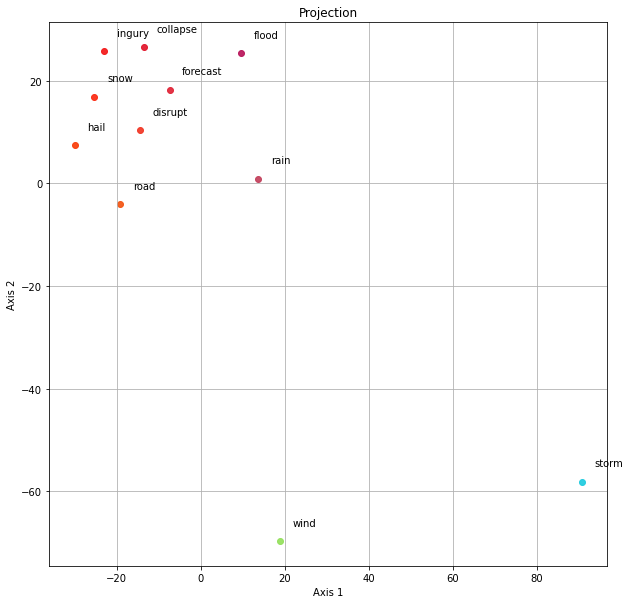

In [22]:
# Let's run MDS based on the absolute counts of the keyword occurrences
mds1 = MDS(n_components = 2, random_state=110)
mds1.fit(kw_abs_counts)
xy_mds1 = mds1.fit_transform(kw_abs_counts)

# Let us visualize the result in a scatter plot
plt.figure(figsize=(10,10))
plt.xlabel('Axis 1')
plt.ylabel('Axis 2')
plt.title('Projection')
colors = [(0,0,0)]
for i in range(len(xy_mds1)):
    plt.scatter(xy_mds1[i,0], 
                xy_mds1[i,1], 
                alpha = .9, 
                c=getColor(xy_mds1[i,0], 
                           xy_mds1[i,1],
                           xy_mds1[:,0].min(), 
                           xy_mds1[:,0].max(),
                           xy_mds1[:,1].min(), 
                           xy_mds1[:,1].max()))

for i in range(len(xy_mds1)):
    plt.text(xy_mds1[i,0]+3, xy_mds1[i,1]+3,kw.Name[i])
    
plt.grid()

##### Check the data frame before and after it is rescaled

In [23]:
kw_abs_counts.head()

27.03;00  27.03;01  27.03;02  27.03;03  27.03;04  27.03;05  27.03;06  \
id                                                                            
storm         0         1         0         0         1         0         6   
wind          0         0         0         0         1         0         1   
rain          0         0         0         0         0         0         2   
snow          0         0         0         0         0         0         0   
hail          0         0         0         0         0         0         0   

       27.03;07  27.03;08  27.03;09  ...  02.04;04  02.04;05  02.04;06  \
id                                   ...                                 
storm         3         2         5  ...         0         2         1   
wind          1         0         2  ...         0         0         3   
rain          3         0         1  ...         1         0         1   
snow          0         0         0  ...         0         0         0   
hail          0         0         0  ...         0         1         1   

       02.04;07  02.04;08  02.04;09  02.04;10  02.04;11  02.04;12  02.04;13  
id                                                                           
storm         2         3         1         8         7         6         4  
wind          2         1         0         0         0         1         0  
rain          3         0         0         0         3         0         0  
snow          0         0         0         0         0         1         0  
hail          1         1         0         0         0         0         0  

[5 rows x 158 columns]

In [24]:
xy_mds1

array([[ 90.63974204, -58.15576108],
       [ 18.8102401 , -69.70418511],
       [ 13.70669162,   0.90168238],
       [-25.30391647,  16.92914224],
       [-29.97302438,   7.45652616],
       [  9.57614995,  25.45831962],
       [-19.12928892,  -4.01581806],
       [-13.44820393,  26.62471474],
       [-22.92192445,  25.79122095],
       [-14.53956313,  10.44441335],
       [ -7.41690243,  18.2697448 ]])

In [25]:
kw_abs_counts.shape

(11, 158)

In [26]:
xy_mds1.shape

(11, 2)

##### Comments

Here, the column dimension of **kw_abs_counts** has been scaled down from 158 to 2, to plot it in a 2-axis visual.

## Task: observe and interpret the spatial distribution of the dots in the plot
Does the distribution include spatial clusters? Spatial Outliers? What do they mean? Which keywords have similar hourly occurrences? Which keywords are very dissimilar to all others (in terms of the hourly occurrences)? 

### Visualise the temporal profiles of the keyword occurrence
We build a line graph (or line plot) where there is a line for each keyword showing the temporal variation of the number of the keyword occurrences. The lines are painted in the same colours as the dots in the projection plot. Hence, the colours of the lines indicate the positions of the data items in the projection.

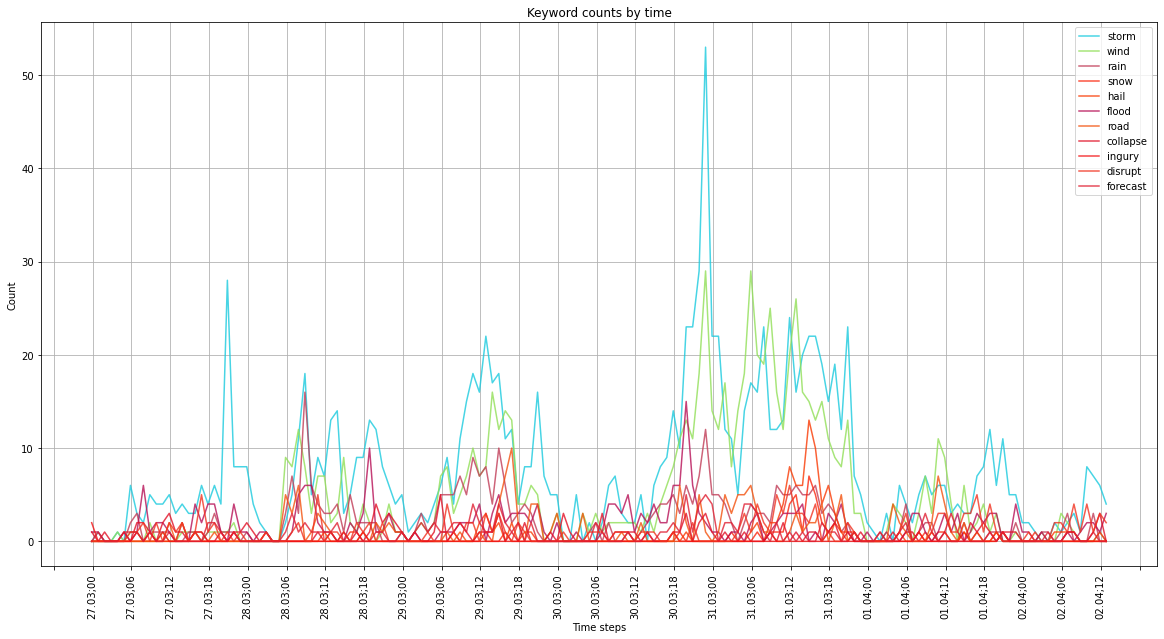

In [27]:
plt.figure(figsize=(20,10))
plt.xlabel('Time steps')
plt.ylabel('Count')
plt.title('Keyword counts by time')

i=0

for index, row in kw_abs_counts.iterrows():
    plt.plot(kw_abs_counts.columns, 
             row,  
             alpha = .8, 
             color=getColor(xy_mds1[i,0], 
                            xy_mds1[i,1],
                            xy_mds1[:,0].min(), 
                            xy_mds1[:,0].max(),
                            xy_mds1[:,1].min(), 
                            xy_mds1[:,1].max()), 
             label=row.name)
    i=i+1

plt.legend()
plt.xticks(rotation=90)
start, end = plt.xlim()
plt.xticks(np.arange(start+2, end, 6))
plt.grid()
   
plt.show()

## Task: use the line graph to explain the patterns observed in the spatialisation
The line graph shows the data from which the spatialisation was derived. It allows you to understand the similarities and differences between the data items that lead to the particular spatial arrangement of the dots in the projection.

### Selection of regions in the projection plot for detailed examination of the data
In the absence of interactive tools to select data directly in a visual display, we shall simulate interactive selection of regions in the projection plot for a more detailed examination of the data corresponding to the points contained in these regions. In plotting the data, we use an "if" statement for selecting the rows to plot according to the coordinates of the corresponding points in the projection.

#### Please edit the conditions in the "if" statement to select and inspect different regions of the projection plot!

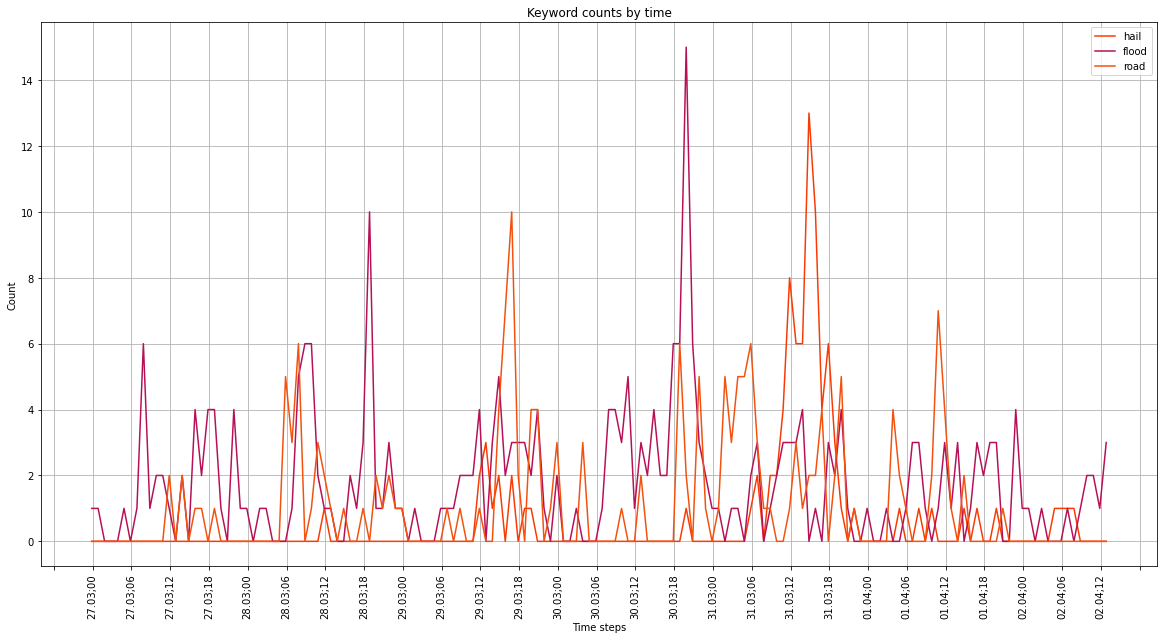

In [28]:
plt.figure(figsize=(20,10))
plt.xlabel('Time steps')
plt.ylabel('Count')
plt.title('Keyword counts by time')

i=0
for index, row in kw_abs_counts.iterrows():
    if (xy_mds1[i,0]<0 and xy_mds1[i,1]<10) or (xy_mds1[i,0]>0 and xy_mds1[i,1]>20) : 
        # Edit these conditions to select other regions
            plt.plot(kw_abs_counts.columns, row, 
                    color=getColor(xy_mds1[i,0], xy_mds1[i,1],
                                   xy_mds1[:,0].min(), xy_mds1[:,0].max(),
                                   xy_mds1[:,1].min(), xy_mds1[:,1].max()), 
                label=row.name)
    i=i+1

plt.legend()
plt.xticks(rotation=90)
start, end = plt.xlim()
plt.xticks(np.arange(start+2, end, 6))
plt.grid()
   
plt.show()

### Spatialisation of keywords according to the hourly percentages of the occurrences
We apply the same sequence of operations to the selection of the columns with the percentages as we previously did for the columns with the absolute counts. We create a 2D projection, observe the spatial distribution of the dots, and try to understand the similarities and differences between the data items using a line graph.

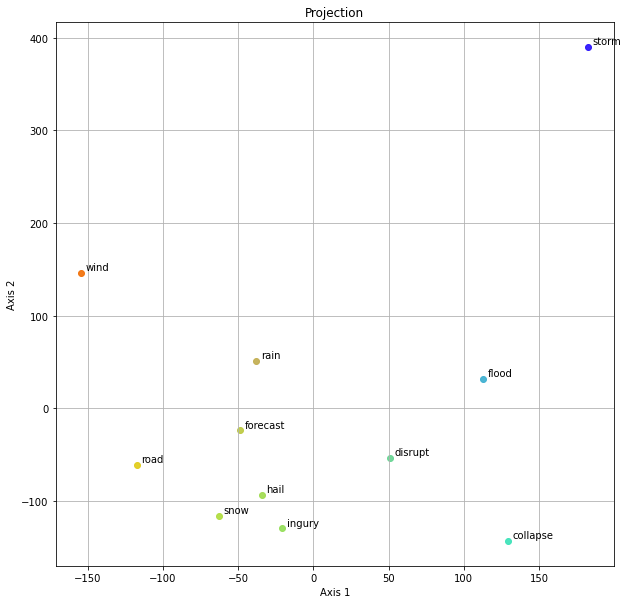

In [29]:
# Let's now run MDS based on the percentages of the keyword occurrences
mds2 = MDS(n_components = 2, random_state=102)
mds2.fit(kw_percentages)
xy_mds2 = mds2.fit_transform(kw_percentages)

# Let us visualize the result in a scatter plot
plt.figure(figsize=(10,10))
plt.xlabel('Axis 1')
plt.ylabel('Axis 2')
plt.title('Projection')
colors = [(0,0,0)]
for i in range(len(xy_mds2)):
    plt.scatter(xy_mds2[i,0], 
                xy_mds2[i,1], 
                alpha = .9, 
                c=getColor(xy_mds2[i,0], 
                           xy_mds2[i,1],
                           xy_mds2[:,0].min(), 
                           xy_mds2[:,0].max(), 
                           xy_mds2[:,1].min(), 
                           xy_mds2[:,1].max()))

for i in range(len(xy_mds2)):
    plt.text(xy_mds2[i,0]+3, xy_mds2[i,1]+3,kw.Name[i])

plt.grid()

In [30]:
kw_percentages.head()

27.03;00  27.03;01  27.03;02  27.03;03  27.03;04  27.03;05  27.03;06  \
id                                                                            
storm       0.0      33.3       0.0       0.0      50.0       0.0      54.5   
wind        0.0       0.0       0.0       0.0      50.0       0.0       9.1   
rain        0.0       0.0       0.0       0.0       0.0       0.0      18.2   
snow        0.0       0.0       0.0       0.0       0.0       0.0       0.0   
hail        0.0       0.0       0.0       0.0       0.0       0.0       0.0   

       27.03;07  27.03;08  27.03;09  ...  02.04;04  02.04;05  02.04;06  \
id                                   ...                                 
storm      23.1      16.7      41.7  ...       0.0      40.0      12.5   
wind        7.7       0.0      16.7  ...       0.0       0.0      37.5   
rain       23.1       0.0       8.3  ...      50.0       0.0      12.5   
snow        0.0       0.0       0.0  ...       0.0       0.0       0.0   
hail        0.0       0.0       0.0  ...       0.0      20.0      12.5   

       02.04;07  02.04;08  02.04;09  02.04;10  02.04;11  02.04;12  02.04;13  
id                                                                           
storm      16.7      27.3      33.3      57.1      46.7      40.0      44.4  
wind       16.7       9.1       0.0       0.0       0.0       6.7       0.0  
rain       25.0       0.0       0.0       0.0      20.0       0.0       0.0  
snow        0.0       0.0       0.0       0.0       0.0       6.7       0.0  
hail        8.3       9.1       0.0       0.0       0.0       0.0       0.0  

[5 rows x 158 columns]

In [31]:
xy_mds2

array([[ 182.81244821,  390.15146096],
       [-154.42287617,  146.52336904],
       [ -37.91376366,   51.61937699],
       [ -62.47365713, -116.28176235],
       [ -34.27531729,  -93.1645775 ],
       [ 112.61697351,   32.02911631],
       [-117.5272094 ,  -61.28721992],
       [ 129.71364543, -143.15719795],
       [ -20.64632547, -129.43685938],
       [  50.83236603,  -53.18848512],
       [ -48.71628406,  -23.80722107]])

In [32]:
kw_percentages.shape

(11, 158)

In [33]:
xy_mds2.shape

(11, 2)

##### Comments

Here, the column dimension of **kw_percentages** has been scaled down from 158 to 2, to plot it in a 2-axis visual.

## Task: compare the projections obtained from the absolute counts and from the percentages
What are the major differences between the projections, particularly, in terms of the presence of spatial clusters and outliers?

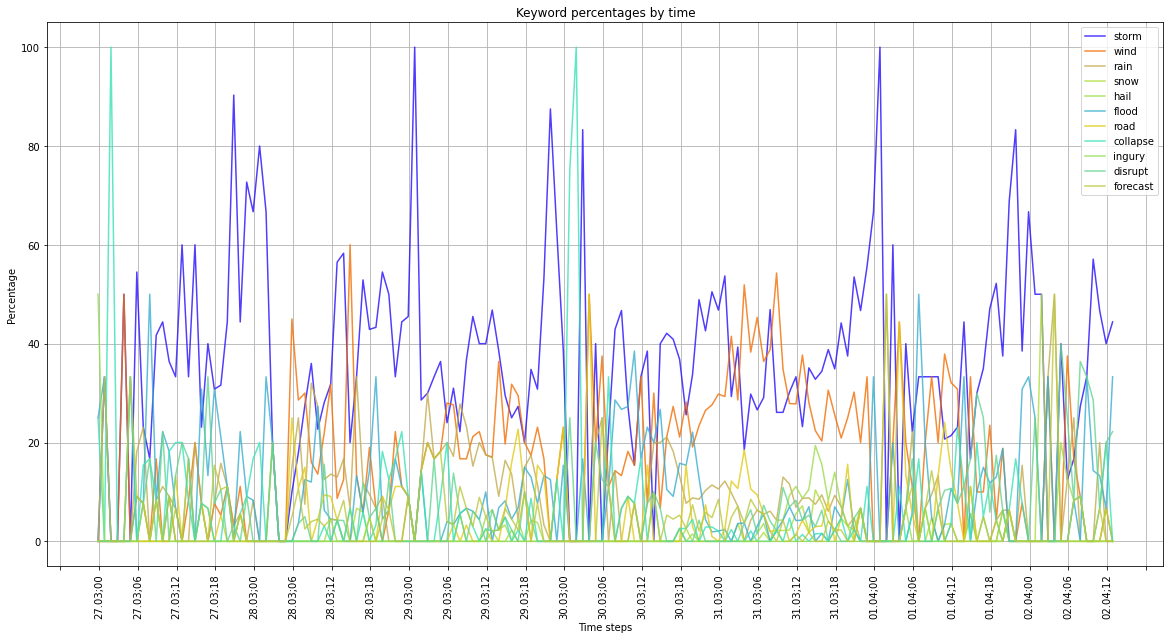

In [34]:
plt.figure(figsize=(20,10))
plt.xlabel('Time steps')
plt.ylabel('Percentage')
plt.title('Keyword percentages by time')

i=0
for index, row in kw_percentages.iterrows():
    plt.plot(kw_percentages.columns, 
             row,  alpha = .8,
             color=getColor(xy_mds2[i,0], 
                            xy_mds2[i,1],
                            xy_mds2[:,0].min(), 
                            xy_mds2[:,0].max(),
                            xy_mds2[:,1].min(), 
                            xy_mds2[:,1].max()), 
             label=row.name)
    i=i+1
    
plt.legend()
plt.xticks(rotation=90)
start, end = plt.xlim()
plt.xticks(np.arange(start+2, end, 6))
plt.grid()

plt.show()

## Task: note the differences between the line graphs showing the absolute counts and the percentages
There aren't so large differences between the percentages as there are between the absolute counts. How is this difference related to the differences between the spatial distributions of the dots in the corresponding projections? 

### Selection of regions in the projection plot for detailed examination of the data
Like for the previous projection plot, we shall select plot regions for detailed examination using an "if" statement in the code for plotting lines in the line graph.

#### Please edit the conditions in the "if" statement to select and inspect different regions of the projection plot!


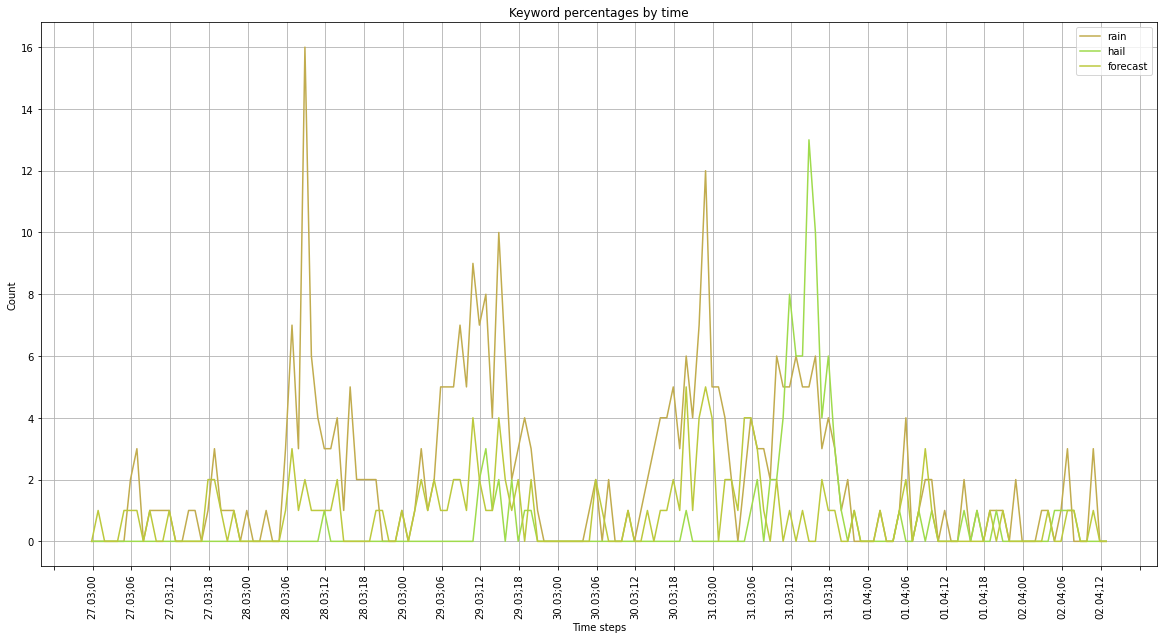

In [35]:
plt.figure(figsize=(20,10))
plt.xlabel('Time steps')
plt.ylabel('Count')
plt.title('Keyword percentages by time')

i=0
for index, row in kw_abs_counts.iterrows():
    if xy_mds2[i,0]>-100 and xy_mds2[i,0]<0 and xy_mds2[i,1]>-100 and xy_mds2[i,1]<100 :
        # Edit these conditions to select other regions
        plt.plot(kw_percentages.columns, row, 
                 color=getColor(xy_mds2[i,0], 
                                xy_mds2[i,1],
                                xy_mds2[:,0].min(), 
                                xy_mds2[:,0].max(),
                                xy_mds2[:,1].min(), 
                                xy_mds2[:,1].max()), 
                 label=row.name)
    i=i+1

plt.legend()
plt.xticks(rotation=90)
start, end = plt.xlim()
plt.xticks(np.arange(start+2, end, 6))
plt.grid()
   
plt.show()

## 2. Spatialisation of time steps

### Transposition of the data
To apply spatialisation to the hourly time steps instead of the keywords, we transpose the data tables so that the time steps correspond to table rows and keywords to the columns. We do the transposition for the absolute counts and for the percentages.

In [36]:
# Let us transpose the columns containing the absolute counts
counts_by_time = kw_abs_counts.T
counts_by_time.columns=kw.iloc[:, 0]
counts_by_time.head()

id        storm  wind  rain  snow  hail  flood  road  collapse  ingury  \
27.03;00      0     0     0     0     0      1     0         1       2   
27.03;01      1     0     0     0     0      1     0         0       0   
27.03;02      0     0     0     0     0      0     0         1       0   
27.03;03      0     0     0     0     0      0     0         0       0   
27.03;04      1     1     0     0     0      0     0         0       0   

id        disrupt  forecast  
27.03;00        0         0  
27.03;01        0         1  
27.03;02        0         0  
27.03;03        0         0  
27.03;04        0         0

In [37]:
# Let us transpose the columns containing the percentages
perc_by_time = kw_percentages.T
perc_by_time.columns=kw.iloc[:, 0]
perc_by_time.head()

id        storm  wind  rain  snow  hail  flood  road  collapse  ingury  \
27.03;00    0.0   0.0   0.0   0.0   0.0   25.0   0.0      25.0    50.0   
27.03;01   33.3   0.0   0.0   0.0   0.0   33.3   0.0       0.0     0.0   
27.03;02    0.0   0.0   0.0   0.0   0.0    0.0   0.0     100.0     0.0   
27.03;03    0.0   0.0   0.0   0.0   0.0    0.0   0.0       0.0     0.0   
27.03;04   50.0  50.0   0.0   0.0   0.0    0.0   0.0       0.0     0.0   

id        disrupt  forecast  
27.03;00      0.0       0.0  
27.03;01      0.0      33.3  
27.03;02      0.0       0.0  
27.03;03      0.0       0.0  
27.03;04      0.0       0.0

### Application of MDS to the time steps characterised by the absolute keyword counts

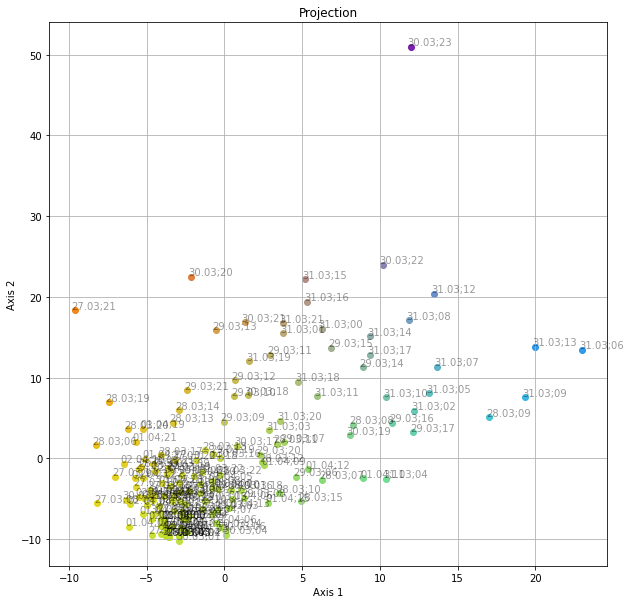

In [38]:
# Let's apply MDS to the transposed table with the counts
mds3 = MDS(n_components = 2, random_state=17)
mds3.fit(counts_by_time)
xy_mds3 = mds3.fit_transform(counts_by_time)

# Let us visualize the result in a scatter plot
plt.figure(figsize=(10,10))
plt.xlabel('Axis 1')
plt.ylabel('Axis 2')
plt.title('Projection')
colors = [(0,0,0)]
for i in range(len(xy_mds3)):
    plt.scatter(xy_mds3[i,0], 
                xy_mds3[i,1], 
                alpha = .9, 
                c=getColor(xy_mds3[i,0], 
                           xy_mds3[i,1],
                           xy_mds3[:,0].min(), 
                           xy_mds3[:,0].max(),
                           xy_mds3[:,1].min(), 
                           xy_mds3[:,1].max()))

# Connecting consecutive points by lines
#plt.plot(xy_mds3[:,0],xy_mds3[:,1], linestyle=':')  

for i in range(len(xy_mds3)):
    plt.text(xy_mds3[i,0]-0.2, 
             xy_mds3[i,1]+0.2,
             counts_by_time.index[i], 
             alpha = .4)
    
plt.grid()    

In [39]:
counts_by_time.head()

id        storm  wind  rain  snow  hail  flood  road  collapse  ingury  \
27.03;00      0     0     0     0     0      1     0         1       2   
27.03;01      1     0     0     0     0      1     0         0       0   
27.03;02      0     0     0     0     0      0     0         1       0   
27.03;03      0     0     0     0     0      0     0         0       0   
27.03;04      1     1     0     0     0      0     0         0       0   

id        disrupt  forecast  
27.03;00        0         0  
27.03;01        0         1  
27.03;02        0         0  
27.03;03        0         0  
27.03;04        0         0

In [40]:
xy_mds3

array([[-4.68718430e+00, -9.44230447e+00],
       [-3.85313687e+00, -8.46466240e+00],
       [-3.78385516e+00, -9.59300105e+00],
       [-3.56379901e+00, -9.66068429e+00],
       [-2.81211583e+00, -8.54866906e+00],
       [-4.05371773e+00, -9.32053347e+00],
       [-2.89935176e+00, -3.09463718e+00],
       [-1.44620272e+00, -6.21197807e+00],
       [-8.16927037e+00, -5.53764989e+00],
       [-2.25213059e+00, -4.03616754e+00],
       [-4.64590892e+00, -4.97192045e+00],
       [-3.32244297e+00, -4.97256353e+00],
       [-5.68831883e+00, -3.48762347e+00],
       [-4.13657775e+00, -6.68856834e+00],
       [-3.87933762e+00, -4.64601766e+00],
       [-2.70089371e+00, -6.57812027e+00],
       [-4.58995525e+00, -5.15000461e+00],
       [-7.03792241e+00, -2.24529954e+00],
       [-4.79419100e+00, -3.89294784e+00],
       [-3.52515594e+00, -1.50219334e+00],
       [-2.86177167e+00, -5.26309466e+00],
       [-9.63224886e+00,  1.83669807e+01],
       [-3.20034822e+00, -1.37595919e-01],
       [-5.

In [41]:
counts_by_time.shape

(158, 11)

In [42]:
xy_mds3.shape

(158, 2)

##### Comments

Here, the column dimension of **counts_by_time** has been scaled down from 158 to 2, to plot it in a 2-axis visual.

## Task: observe and interpret the spatial distribution of the dots in the plot
Do you observe occurrences of the following types of spatial patterns: cluster, dense concentration, spatial outlier, sparsely filled region, density trend? What do these patterns tell you in terms of similarities and differences between the time steps?

### Visualise the temporal distribution of the similarities and differences
We build a 2D time display (time matrix) where the horizontal axis (matrix columns) corresponds to the hours of a day and the vertical axis to the sequence of the days. For each day and hour, we draw a square mark painted in the colour that corresponds to the position of this time step in the projection. Hence, we use colour propagation to acreate a visual link between the projection display and the time matrix. We can observe visual patterns in the distribution of the colours over the time matrix and interpret these patterns as periods of stability and moderate or large changes. 

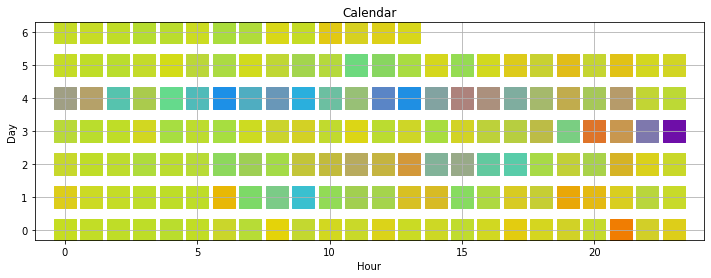

In [43]:
plt.figure(figsize=(12,4))
plt.xlabel('Hour')
plt.ylabel('Day')
plt.title('Calendar')
colors = [(0,0,0)]

plt.grid()

for i in range(len(xy_mds3)):
    plt.scatter(i%24, 
                i//24, 
                alpha = 1, 
                s=500, 
                marker='s', 
                c=getColor(xy_mds3[i,0], 
                           xy_mds3[i,1],
                           xy_mds3[:,0].min(), 
                           xy_mds3[:,0].max(),
                           xy_mds3[:,1].min(), 
                           xy_mds3[:,1].max()))
days = [""]
for d in dates:
    if days[-1]!=d[0:5]:
        days.append(d[0:5])

locs, labels = plt.yticks() 
#plt.yticks(locs,days)
    
plt.show()    

## Task: observe and interpret patterns in the distribution of the colours over the time matrix.

### Visualise the keyword occurrence profiles of the time steps
We build a line graph (or line plot) where there is a line for each time step showing the corresponding counts of the keyword occurrences. The lines are painted in the same colours as the dots in the projection plot. Hence, the colours of the lines indicate the positions of the data items in the projection.

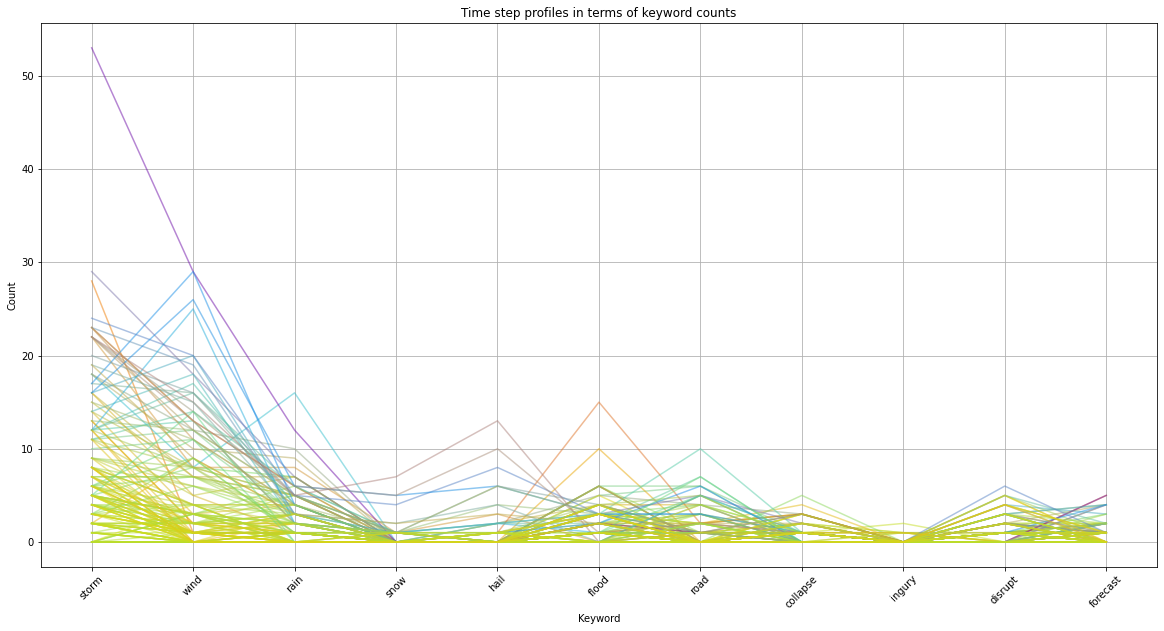

In [44]:
plt.figure(figsize=(20,10))
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.title('Time step profiles in terms of keyword counts')

i=0

for index, row in counts_by_time.iterrows():
    plt.plot(counts_by_time.columns, 
             row, 
             alpha = .5,  
             color=getColor(xy_mds3[i,0], 
                            xy_mds3[i,1],
                            xy_mds3[:,0].min(), 
                            xy_mds3[:,0].max(),
                            xy_mds3[:,1].min(), 
                            xy_mds3[:,1].max()), 
             label=row.name)
    i=i+1

#plt.legend()
plt.xticks(rotation=45)
plt.grid()
   
plt.show()

## Task: use the line graph to explain the patterns seen in the projection plot and time matrix

What can you say about the bulk of the data? Occurrences of which keywords differentiate the data items most? Can you roughly associate some regions of the plot with keywords that occur more frequently than usual?

### Selection of regions in the projection plot for detailed examination of the data
Like previously, we shall select plot regions for detailed examination using an "if" statement in the code for plotting lines in the line graph.

#### Please edit the conditions in the "if" statement to select and inspect different regions of the projection plot!

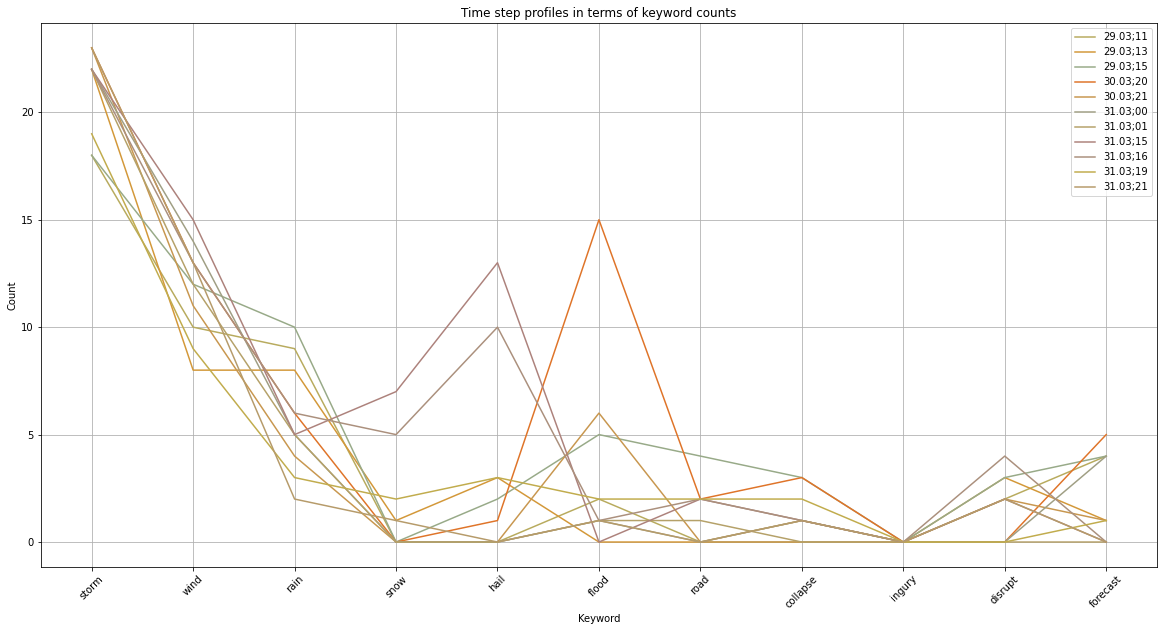

In [45]:
plt.figure(figsize=(20,10))
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.title('Time step profiles in terms of keyword counts')

i=0

for index, row in counts_by_time.iterrows():
    #if xy_mds3[i,0]<-10 and xy_mds3[i,1]>-3 :
    if xy_mds3[i,0]>-5 and xy_mds3[i,0]<7 and xy_mds3[i,1]>10 :
        # Edit these conditions to select other regions
        plt.plot(counts_by_time.columns, 
                 row,
                 color=getColor(xy_mds3[i,0], 
                                xy_mds3[i,1],
                                xy_mds3[:,0].min(), 
                                xy_mds3[:,0].max(),
                                xy_mds3[:,1].min(), 
                                xy_mds3[:,1].max()), 
                 label=row.name)
    i=i+1

plt.legend()
plt.xticks(rotation=45)
plt.grid()
   
plt.show()

### Application of MDS to the time steps characterised by the relative keyword frequencies

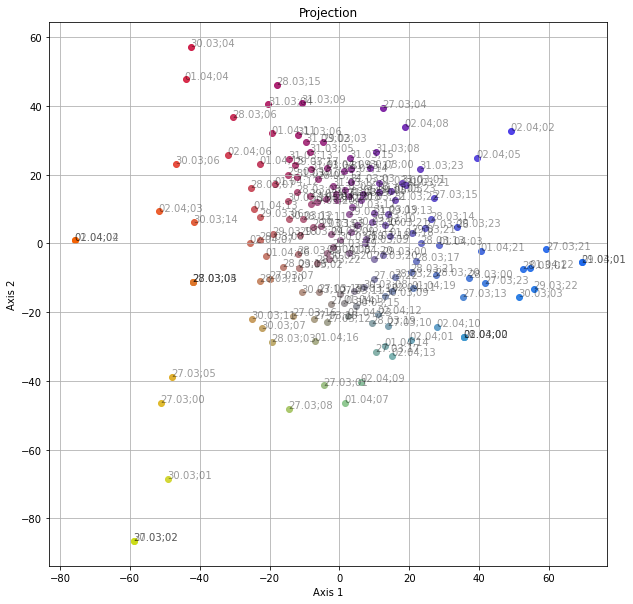

In [46]:
# Let's apply MDS to the transposed table with the percentages
mds4 = MDS(n_components = 2, random_state=2)
mds4.fit(perc_by_time)
xy_mds4 = mds4.fit_transform(perc_by_time)

# Let us visualize the result in a scatter plot
plt.figure(figsize=(10,10))
plt.xlabel('Axis 1')
plt.ylabel('Axis 2')
plt.title('Projection')
colors = [(0,0,0)]

for i in range(len(xy_mds4)):
    plt.scatter(xy_mds4[i,0], 
                xy_mds4[i,1], 
                alpha = .9, 
                c=getColor(xy_mds4[i,0], 
                           xy_mds4[i,1],
                           xy_mds4[:,0].min(), 
                           xy_mds4[:,0].max(),
                           xy_mds4[:,1].min(), 
                           xy_mds4[:,1].max()))

# Connecting consecutive points by lines
#plt.plot(xy_mds4[:,0],xy_mds4[:,1], linestyle=':')  

for i in range(len(xy_mds4)):
    plt.text(xy_mds4[i,0]-0.2, 
             xy_mds4[i,1]+0.2,
             counts_by_time.index[i], 
             alpha=.4)
    
plt.grid()

In [47]:
perc_by_time.head()

id        storm  wind  rain  snow  hail  flood  road  collapse  ingury  \
27.03;00    0.0   0.0   0.0   0.0   0.0   25.0   0.0      25.0    50.0   
27.03;01   33.3   0.0   0.0   0.0   0.0   33.3   0.0       0.0     0.0   
27.03;02    0.0   0.0   0.0   0.0   0.0    0.0   0.0     100.0     0.0   
27.03;03    0.0   0.0   0.0   0.0   0.0    0.0   0.0       0.0     0.0   
27.03;04   50.0  50.0   0.0   0.0   0.0    0.0   0.0       0.0     0.0   

id        disrupt  forecast  
27.03;00      0.0       0.0  
27.03;01      0.0      33.3  
27.03;02      0.0       0.0  
27.03;03      0.0       0.0  
27.03;04      0.0       0.0

In [48]:
xy_mds4

array([[-5.10601193e+01, -4.64612555e+01],
       [-4.49901125e+00, -4.12964576e+01],
       [-5.88006405e+01, -8.66178971e+01],
       [-4.18551563e+01, -1.11427353e+01],
       [ 1.23841790e+01,  3.94070426e+01],
       [-4.79657435e+01, -3.89254647e+01],
       [ 2.46173521e+01,  4.60479103e+00],
       [-1.97939651e+01, -1.04095616e+01],
       [-1.43107657e+01, -4.80946866e+01],
       [ 7.23019956e+00,  2.25471129e-01],
       [ 1.40116719e+01, -2.40828183e+01],
       [ 8.31953565e-02, -1.47665516e+01],
       [-3.43586800e+00, -2.28787702e+01],
       [ 3.53794626e+01, -1.55248862e+01],
       [-2.39587126e+00, -1.75208494e+01],
       [ 2.70667542e+01,  1.31804741e+01],
       [-1.32418627e+01, -2.11665044e+01],
       [ 1.05658939e+01, -3.14905137e+01],
       [-7.34740466e+00, -2.19467243e+01],
       [-5.82748026e+00, -1.41979183e+01],
       [ 9.87716934e+00, -4.59408963e+00],
       [ 5.92782498e+01, -1.70156206e+00],
       [ 9.95076040e+00, -1.02381411e+01],
       [ 4.

In [49]:
perc_by_time.shape

(158, 11)

In [50]:
xy_mds4.shape

(158, 2)

##### Comments

Here, the column dimension of **perc_by_time** has been scaled down from 158 to 2, to plot it in a 2-axis visual.

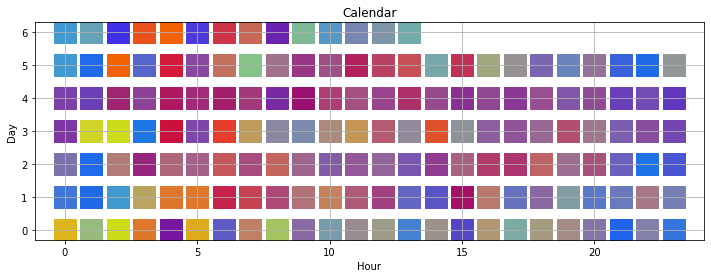

In [51]:
plt.figure(figsize=(12,4))
plt.xlabel('Hour')
plt.ylabel('Day')
plt.title('Calendar')
colors = [(0,0,0)]

plt.grid()

for i in range(len(xy_mds4)):
    plt.scatter(i%24, 
                i//24, 
                alpha = 1, 
                s=500, 
                marker='s', 
                c=getColor(xy_mds4[i,0], 
                           xy_mds4[i,1],
                           xy_mds4[:,0].min(), 
                           xy_mds4[:,0].max(),
                           xy_mds4[:,1].min(), 
                           xy_mds4[:,1].max()))

locs, labels = plt.yticks() 
#plt.yticks(locs,days)
    
plt.show()    

## Task: compare the projections obtained from the absolute counts and from the percentages
What are the major differences between the projections in terms of the variation of the spatial density and the presence of spatial clusters and outliers? What are the differences between the time matrices linked to the projections? Which matrix exhibits more understandable patterns of colour propagation?

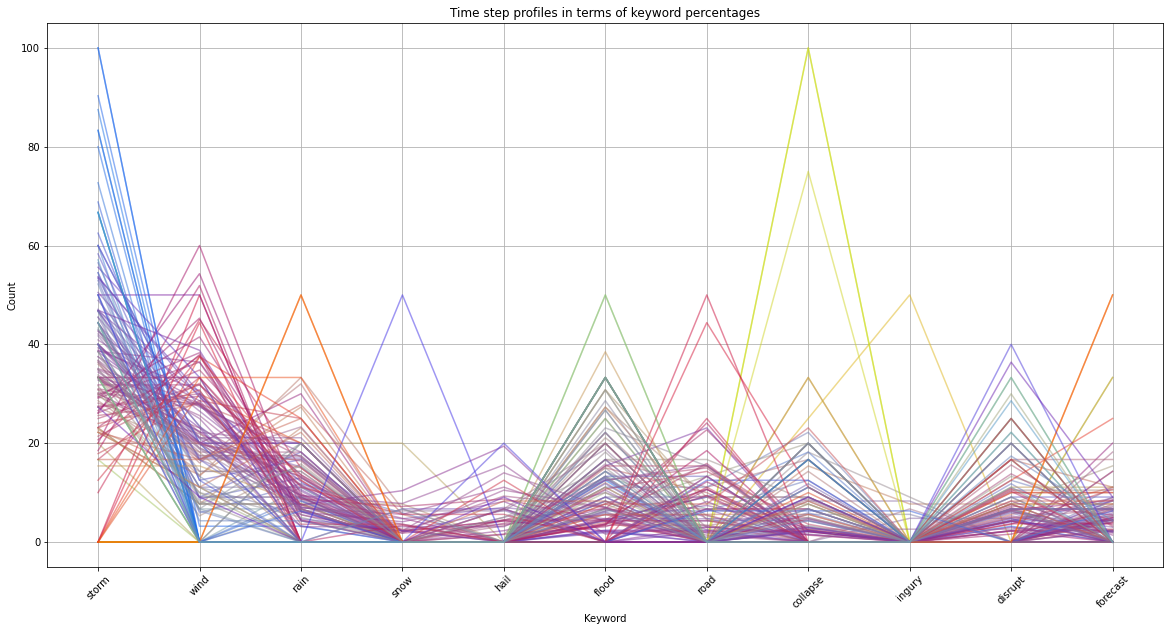

In [52]:
plt.figure(figsize=(20,10))
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.title('Time step profiles in terms of keyword percentages')

i=0

for index, row in perc_by_time.iterrows():
    plt.plot(perc_by_time.columns, 
             row, 
             alpha=0.5, 
             color=getColor(xy_mds4[i,0], 
                            xy_mds4[i,1],
                            xy_mds4[:,0].min(), 
                            xy_mds4[:,0].max(),
                            xy_mds4[:,1].min(), 
                            xy_mds4[:,1].max()), 
             label=row.name)
    i=i+1

#plt.legend()
plt.xticks(rotation=45)
plt.grid()
   
plt.show()

## Task: as previously, try to relate the differences in the projection plots for the counts and percentages to the differences in the corresponding line graphs.

### Selection of regions in the projection plot for detailed examination of the data

#### Please edit the conditions in the "if" statement to select and inspect different regions of the projection plot!

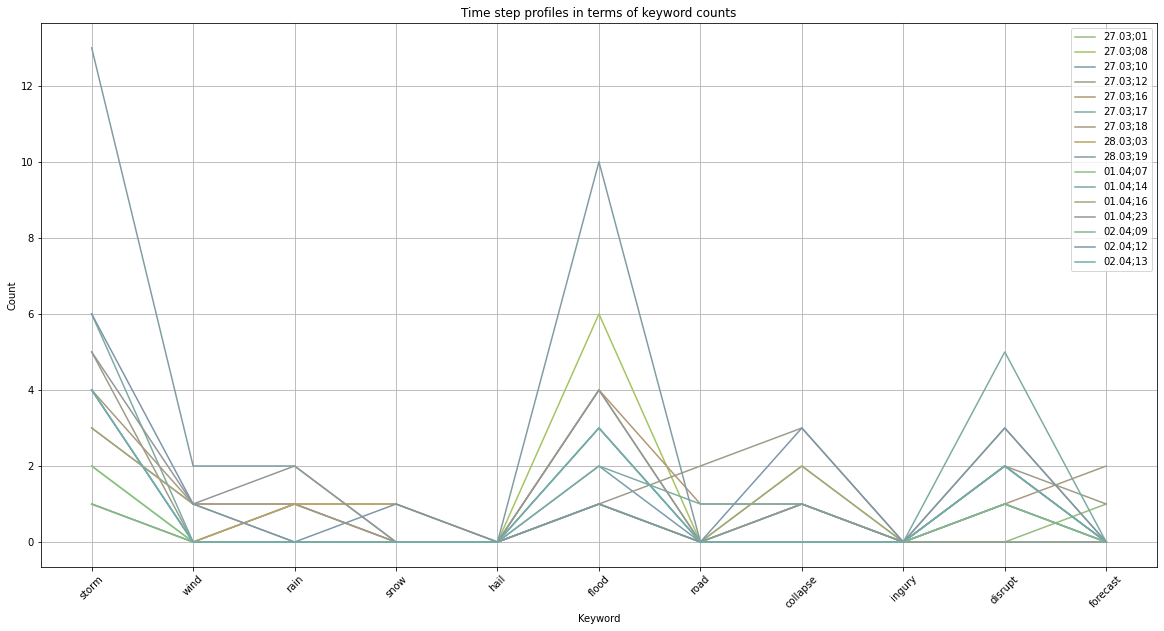

In [53]:
plt.figure(figsize=(20,10))
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.title('Time step profiles in terms of keyword counts')

i=0
for index, row in counts_by_time.iterrows():
    if xy_mds4[i,0]>=-20 and xy_mds4[i,0]<=20 and xy_mds4[i,1]<=-20 :
        # Edit these conditions to select other regions
        plt.plot(perc_by_time.columns, 
                 row, 
                 color=getColor(xy_mds4[i,0], 
                                xy_mds4[i,1],
                                xy_mds4[:,0].min(), 
                                xy_mds4[:,0].max(),
                                xy_mds4[:,1].min(), 
                                xy_mds4[:,1].max()), 
                 label=row.name)
    i=i+1

plt.legend()
plt.xticks(rotation=45)
plt.grid()
   
plt.show()